# Female headed households with low income in South Africa
### - Prediction of a keyindicator
-----------------------------

__*Summary*__:

We developed a machine learning model to predict the percentage of female headed households per ward in South Africa. The best result was archieved by XGBoost with a RMSE of 3.92. Further, we found, that the best predictors are school attendance and the ownership of a car and/or land ownership.

-------------

__*Objective*__: 

In South Africa, the number of female headed households is increasing. Low income and social challenges puts women at high risk for poverty. Non-Profits are interested to estimate the aid and support for those low income households. 

In this project, we develop a machine learning model to predict the percentage of female headed households with income under 19,600 R per year per ward.

__*Value of the product*__:    

Monitor the percentage of female headed households between census years. Since female-headed households are prone to poverty, the stakeholder (a NGO) uses it as a keyindicator to estimate the amount of relief supplies in certain regions of South Africa.

__*Data*__: 
+ derived from Zindi ([link](https://zindi.africa/competitions/womxn-in-big-data-south-africa-female-headed-households-in-south-africa))
+ data are aggregated from south-african census 2011
+ 2822 observations, 64 variables
+ variables from survey: housing forms, school attendance, access to water etc
+ all variables are expressed as percentage

__*Methods*__:
+ Regression methods (linear regression, random forest, gradient boosting)
+ identification of good predictors (features)
+ predict per ward

__*Evaluation metrics*__:
R2 and RMSE

# Data Exploration and cleaning
------------------------------------


In [59]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

RSEED = 42



## Data import 

In [18]:
# Load the data
df = pd.read_csv("data/Train.csv")
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [19]:
# Check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward               2822 non-null   object 
 1   total_households   2822 non-null   float64
 2   total_individuals  2822 non-null   float64
 3   target             2822 non-null   float64
 4   dw_00              2822 non-null   float64
 5   dw_01              2822 non-null   float64
 6   dw_02              2822 non-null   float64
 7   dw_03              2822 non-null   float64
 8   dw_04              2822 non-null   float64
 9   dw_05              2822 non-null   float64
 10  dw_06              2822 non-null   float64
 11  dw_07              2822 non-null   float64
 12  dw_08              2822 non-null   float64
 13  dw_09              2822 non-null   float64
 14  dw_10              2822 non-null   float64
 15  dw_11              2822 non-null   float64
 16  dw_12              2822 

In [20]:
# Check for missing values
df.isnull().sum()

ward                 0
total_households     0
total_individuals    0
target               0
dw_00                0
                    ..
pw_08                0
ADM4_PCODE           0
lat                  0
lon                  0
NL                   0
Length: 63, dtype: int64

In [21]:
# Check for duplicates
df.duplicated().sum()

0

Findings: 

+ Data are mostly numerical
+ casted in the right datatype
+ no missing values found
+ no duplicates found

-> no cleaning is needed at this point

## Distribution of the target

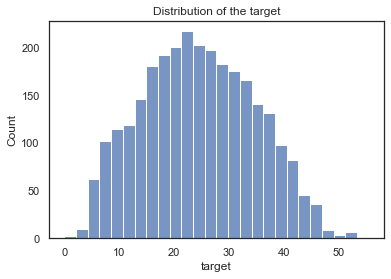

In [22]:
# Histogram of the target 
sns.histplot(df.target).set_title("Distribution of the target")
sns.set_theme(style="darkgrid");

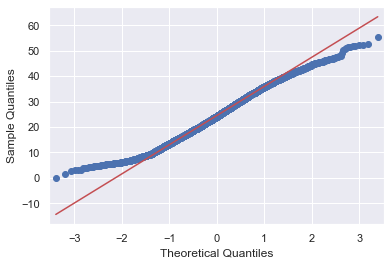

In [23]:
# QQ- plot of the data
sm.qqplot(df.target, line="q")
sns.set_theme(style="darkgrid")
plt.show()

Conclusion: The target is normally distributed.

## Relationships and correlations

The strength of a relationship between target and variable can be expressed as correlation. To identify features that are correlated with the target, the correlation is visualized in a heatmap and the highest correlations will be checked. The highest correlated features are selected on how allegeable they are for the model. Colinear features are excluded.


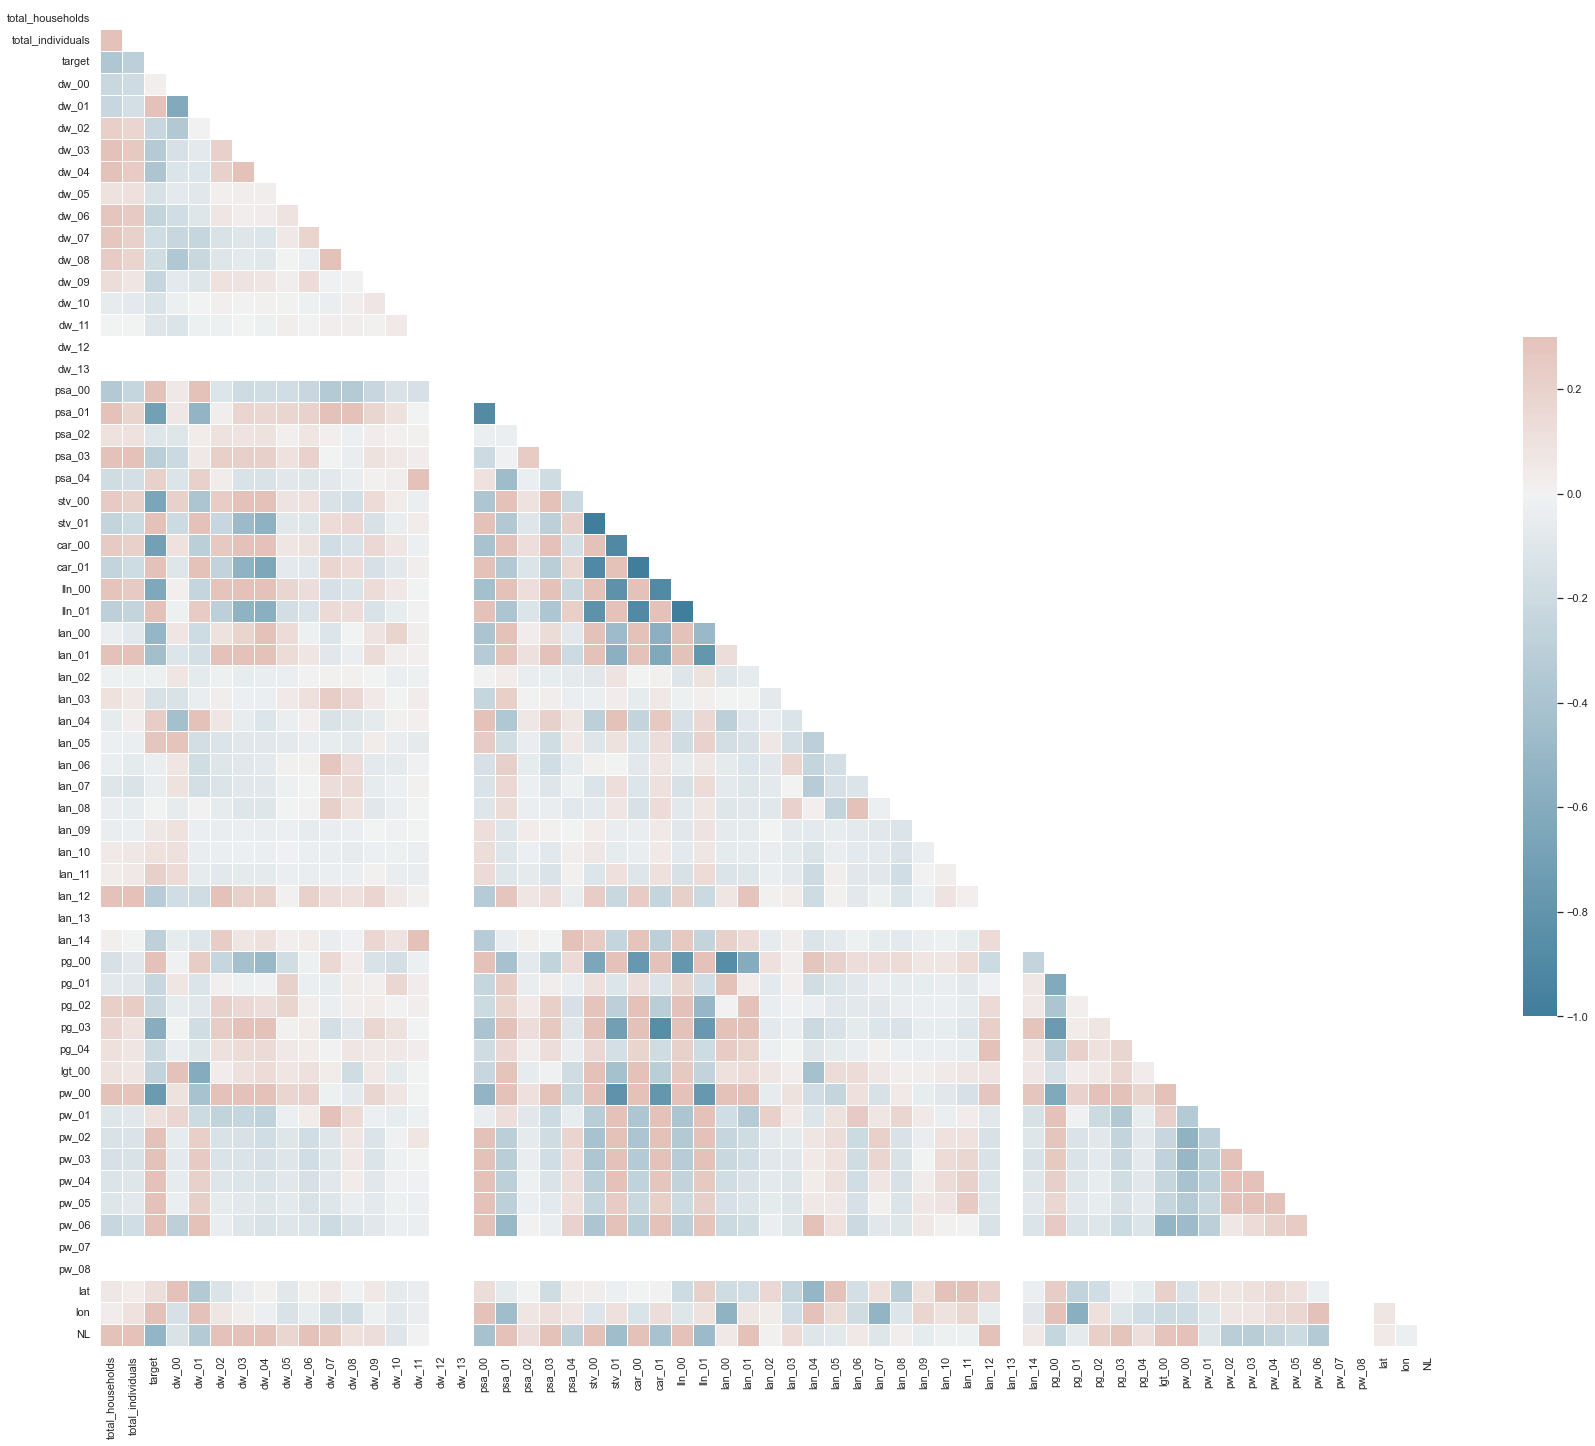

In [24]:
# Setting style for the heatmap
sns.set_theme(style="white")

# Calculate a correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

__Findings on the heatmap:___ 

+ High positiv correlations can be found with NL, pw_00, pg_03, lan_00, lan_01, lln_00, car_00, stv_00, psa_01
+ High negativ correlation can be found with pw_02 - pw_06, pg_00, lan_04, lan_05, lln_01, car_01, stv_01, psa_00, dw_01
+ The features dw_12, dw_13, lan_13, pw_07, pw_08 do not contain values. The columns have to be checked.
+ The features lln_00/lln_01, car_00/car_01, stv_00/stv_01, psa_00/psa_01 are highly correlated with each other, because they contain yes/no answers.

In [25]:
# Check empty features
df[["dw_12", "dw_13", "lan_13", "pw_07", "pw_08"]].head()

,dw_12,dw_13,lan_13,pw_07,pw_08
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [26]:
#check for zero-values
def identify_zeros(dataframe):
    '''counts all values for each feature that are not zero'''
    for col, data in dataframe.iteritems():
        non_zeros = np.count_nonzero(data.values)
        zeros = len(data.values)- non_zeros
        percent = round((zeros*100)/len(data.values), 1)
        print("The feature", col, "contains", zeros, "Nulls. Percentage:", percent, "%")

In [27]:
# Calculate number of zeros in the features
identify_zeros(df[["dw_12", "dw_13", "lan_13", "pw_07", "pw_08"]])

The feature dw_12 contains 2822 Nulls. Percentage: 100.0 %
The feature dw_13 contains 2822 Nulls. Percentage: 100.0 %
The feature lan_13 contains 2822 Nulls. Percentage: 100.0 %
The feature pw_07 contains 2822 Nulls. Percentage: 100.0 %
The feature pw_08 contains 2822 Nulls. Percentage: 100.0 %


The features dw_12, dw_13, lan_13, pw_07, pw_08 contain only zeros and can be dropped.

In [28]:
# Drop columns that contain zeros only
df.drop(["dw_12", "dw_13", "lan_13", "pw_07", "pw_08"], axis=1, inplace=True)
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.214027,0.019968,0.002848,0.007537,0.000000,0.012928,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.576844,0.018946,0.014566,0.057127,0.019092,0.004131,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.483376,0.083010,0.057560,0.010358,0.001421,0.040881,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.314194,0.002689,0.000000,0.000669,0.000000,0.005011,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.194743,0.009699,0.004859,0.001290,0.000673,0.017629,ZA4161005,-29.409381,25.290165,0.000000


### Identify features with a correlation higher than 0.5

In [116]:
# Create a list of all features that are correlated 
corr_high = corr[abs(corr["target"]) > 0.5]
corr_high =  corr_high.sort_values("target").index.values.tolist()
corr_high

['pw_00',
 'psa_01',
 'car_00',
 'stv_00',
 'lln_00',
 'pg_03',
 'NL',
 'lan_00',
 'pg_00',
 'lln_01',
 'stv_01',
 'car_01',
 'psa_00',
 'target']

### Visual control of features with a correlation higher than 0.5

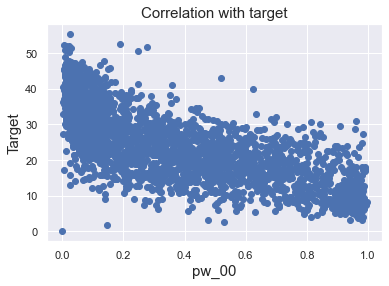

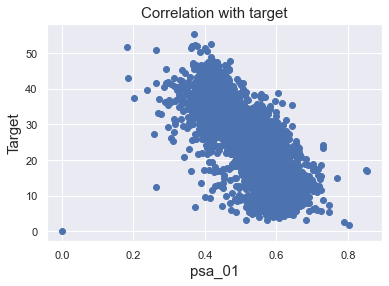

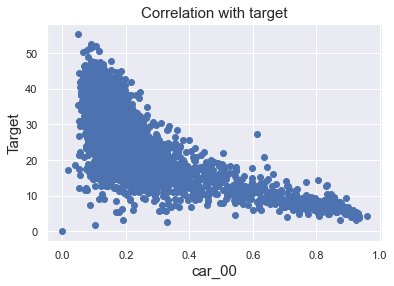

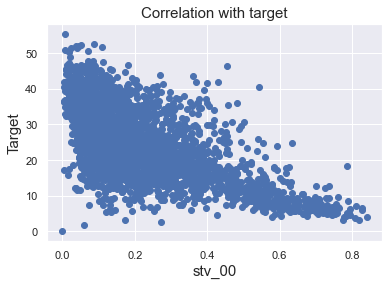

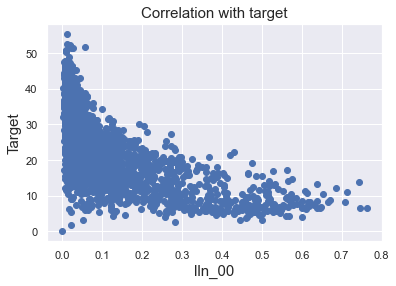

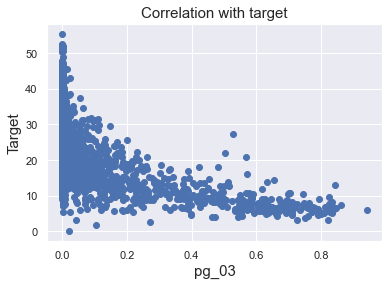

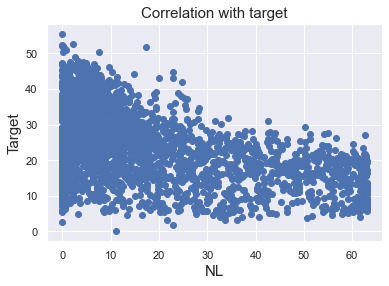

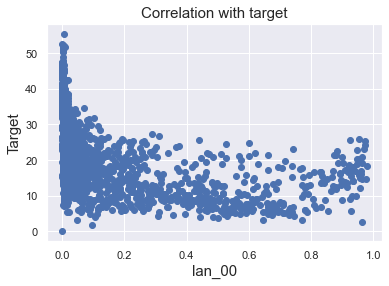

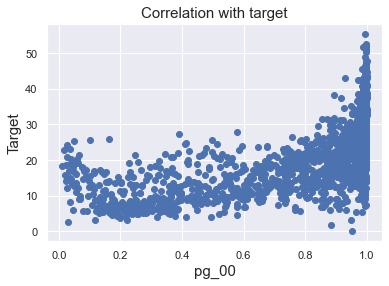

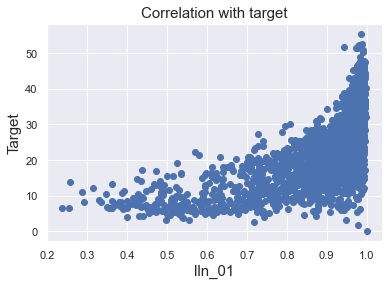

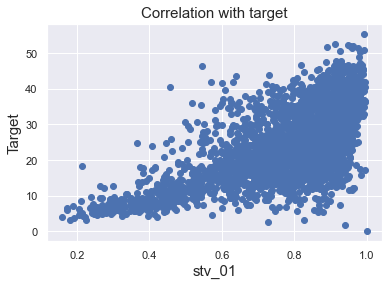

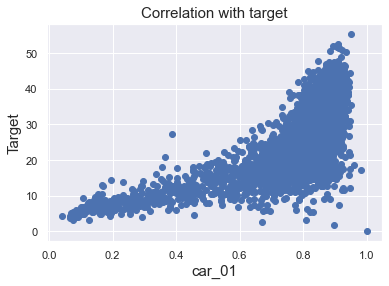

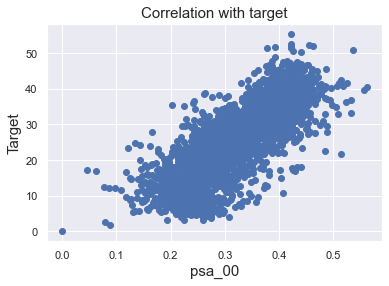

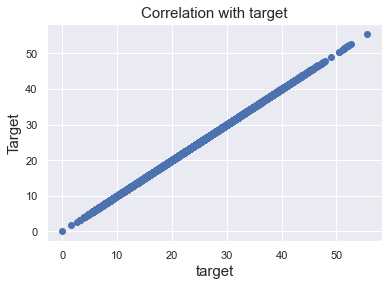

In [129]:
#Plot target and feature with correlation > 0.5
for col, data in df[corr_high].iteritems():
    f, ax = plt.subplots()
    ax.scatter(data.values, df["target"])
    ax.set_xlabel(str(col), fontsize=15)
    ax.set_ylabel("Target", fontsize=15)
    ax.set_title("Correlation with target", fontsize=15)
    sns.set_theme(style="darkgrid")
    plt.show()

Findings: All features are visually correlated, whereby psa_00 and psa_01 seem to be the most promising. However, these features contain the percentage listing present school attendance, psa_00: "Yes", psa_01: "No", and are therefore complementory.

## Conclusions


+ Correlations can be found with 23 features (NL, pw_00, pg_03, lan_00, lan_01, lln_00, car_00, stv_00, psa_01, pw_02 - pw_06, pg_00, lan_04, lan_05, lln_01, car_01, stv_01, psa_00, dw_01).

+ Colinearity: The features lln_00/lln_01, car_00/car_01, stv_00/stv_01, psa_00/psa_01 are highly correlated with each other, because they contain yes/no answers. 

+ The features dw_12, dw_13, lan_13, pw_07, pw_08 do not contain values and were dropped.

